# Uber Eats USA Restaurants and Menus
[Kaggle.com](https://www.kaggle.com/datasets/ahmedshahriarsakib/uber-eats-usa-restaurants-menus)

Quant Squad team
Project Python - Data Science bootcamp

conda install missingno
conda install -c conda-forge geopy


## Initial setup
### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import time
import os
import missingno as msno
from geopy.geocoders import Nominatim
import re 

### File paths on kaggle.com

In [2]:
# paths from kaggle.com
# INPUT
# /kaggle/input/uber-eats-usa-restaurants-menus
# /kaggle/input/uber-eats-usa-restaurants-menus/restaurant-menus.csv
# /kaggle/input/uber-eats-usa-restaurants-menus/restaurants.csv
# OUTPUT
# /kaggle/working/

### Find location on local drive where to put data to have option to run your script on kaggle.com without any changes

In [3]:
# where to put data files from kaggle.com
cwd = os.getcwd()
root_dir = os.path.abspath('/')
print('Put your kaggle/input/uber-eats-usa-restaurants-menus folders in folder\n', root_dir)

Put your kaggle/input/uber-eats-usa-restaurants-menus folders in folder
 D:\


### Load csv files to dataframes

In [4]:
input_directory = "/kaggle/input/uber-eats-usa-restaurants-menus"
input_file_restaurant_menus = '/kaggle/input/uber-eats-usa-restaurants-menus/restaurant-menus.csv'
input_file_restaurants = r"/kaggle/input/uber-eats-usa-restaurants-menus/restaurants.csv"

# measure time
start_time = time.time()

# Read the CSV file into a Pandas dataframe
df_restaurant_menus = pd.read_csv(input_file_restaurant_menus)
df_restaurants = pd.read_csv(input_file_restaurants)

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time, "seconds")

Elapsed time:  10.628302097320557 seconds


### Show basic data about data sources

In [5]:
print("RESTAURANTS:")
print("============")
print("restaurants shape:")
print(df_restaurants.shape,"\n")
print("restaurants datatypes")
print(df_restaurants.dtypes)
print("\n\n")

deleted_rows_restaurants = {'All':df_restaurants.shape[0]}

original_df_restaurants_rows = df_restaurants.shape[0]
original_df_restaurant_menus_rows = df_restaurant_menus.shape[0]

print(deleted_rows_restaurants)
print("RESTAURANT MENUS:")
print("=================")
print("restaurant-menus shape:")
print(df_restaurant_menus.shape,"\n")
print("restaurant-menus datatypes")
print(df_restaurant_menus.dtypes)

if 'position' in df_restaurants.columns:
    df_restaurants.drop('position',axis=1,inplace=True)

if 'zip_code' in df_restaurants.columns:
    df_restaurants.drop('zip_code',axis=1,inplace=True)

if 'description' in df_restaurant_menus.columns:
    df_restaurant_menus.drop('description', axis=1,inplace=True)



RESTAURANTS:
restaurants shape:
(40227, 11) 

restaurants datatypes
id                int64
position          int64
name             object
score           float64
ratings         float64
category         object
price_range      object
full_address     object
zip_code         object
lat             float64
lng             float64
dtype: object



{'All': 40227}
RESTAURANT MENUS:
restaurant-menus shape:
(3375211, 5) 

restaurant-menus datatypes
restaurant_id     int64
category         object
name             object
description      object
price            object
dtype: object


## Data Cleaning
### Restaurants

#### restaurants.id

In [6]:
print("Unique values: ",df_restaurants['id'].unique())
print("Lowest value: ",df_restaurants['id'].min())
print("Highest value: ",df_restaurants['id'].max())
print("Cells without value: ",df_restaurants['id'].isna().sum())
print("Rows: ",df_restaurants.shape[0])
if (df_restaurants['id'].max()==df_restaurants['id'].shape[0]):
    print("It is ok, id=# of rows")
else:
    print("There is gap, id<># of rows")

Unique values:  [    1     2     3 ... 40225 40226 40227]
Lowest value:  1
Highest value:  40227
Cells without value:  0
Rows:  40227
It is ok, id=# of rows


#### restaurants.name

In [7]:
# remove street from name (if exists) and put into separete column 'onlyname')
df_restaurants["onlyname"] = df_restaurants["name"].str.replace(r" \(.*\)","", regex=True).str.strip()

# remove non printable characters
pattern_nonlatin = '[^\x00-\x7F]'
df_restaurants['onlyname'] = df_restaurants['onlyname'].apply(lambda x: re.sub(pattern_nonlatin, '', x))

# remove digits
pattern_digits = '[0-9]'
df_restaurants['onlyname'] = df_restaurants['onlyname'].apply(lambda x: re.sub(pattern_digits, '', x))

# remove html entities
pattern_html = '&\w+;'
df_restaurants['onlyname'] = df_restaurants['onlyname'].apply(lambda x: re.sub(pattern_html, '', x))

# leave only latin characters and space 
pattern_special = '[^a-z A-Z]'
df_restaurants['onlyname'] = df_restaurants['onlyname'].apply(lambda x: re.sub(pattern_special, '', x))

# trim content
df_restaurants['onlyname'] = df_restaurants['onlyname'].str.strip()

# Output Restaurant Chains for potential "long-tail" analysis
# onlyname, categories, count of restaurants
restaurant_chains = df_restaurants.groupby(['onlyname','category']).size().reset_index(name='count').sort_values('count', ascending=False)

#chain = df_restaurants['onlyname'].value_counts()
restaurant_chains.to_csv("output_restaurant_chains.csv", index= False)

print(df_restaurants.shape[0])


40227


#### restaurants.category (Exclude non-restaurants)

In [8]:
# categories that we have qualified as false for restaurants
print(df_restaurants.shape[0])

Categories_to_remove= ['Adult', 'Assorted Stores',
'Beauty Supply','Bookstore','BOGO','ButcherShop','Candy',
'Convenience','Convenience Store with Alcohol','Florist','Flowers',
'Gift Store','Gifts','Grocery','Home & Decor','Home & Personal Care',
'Indoor Plants & Gifts','Liquor Stores','MarketingCampaign',
'OrganicProducts','Personal Care','Pet Shop','Pet Supplies',
'Pharmacy','Plants','Regalos y flores',
'Retail','Smoke Shop','Snack','Snacks','Everyday Essentials','Farmacia'
'Nutrition Supplements','Decor','flores']

# exclude non-restaurant items from "restaurants"

excluded_restaurant_chains = pd.DataFrame()

# group by "onlyname" and choose first category for specific "onlyname"
# (there are cases where same "onlyname" have different set of categories)
# example:
#     McDonalds	American, Burgers, Fast Food
#     McDonalds	American, burger, Fast Food
#     McDonalds	American, Burgers, Fast Food, Fast Food
#     McDonalds	American, Fast Food, Burgers, Group Friendly
# 

excluded_restaurant_chains = df_restaurants.groupby(['onlyname']).agg({'category': ['first', lambda x: ', '\
                    .join(set(ex for ex in Categories_to_remove if ex in x))], 'onlyname': 'size'})\
                    .reset_index()

# rename columns
excluded_restaurant_chains.columns = ['onlyname', 'first_category', 'excluding_words', 'count']    

# set 'exclude' column for 'yes' if there is any word from "Categories_to_remove" in 'first_category'
excluded_restaurant_chains['exclude'] = excluded_restaurant_chains['first_category'].apply(lambda x: 'yes' if x is not None and any(ex in x for ex in Categories_to_remove) else 'no')

# remember words from "Categories_to_remove" found for specific restaurant_chain in "first_category" (for potential verification)
excluded_restaurant_chains['excluding_words'] =excluded_restaurant_chains['first_category'].apply(lambda x: ', '.join([ex for ex in Categories_to_remove if ex in x]) if x else '')

excluded_restaurant_chains=excluded_restaurant_chains.sort_values('count', ascending=False)

#print(excluded_restaurant_chains)

# save for future analysis
excluded_restaurant_chains.to_csv("output_excluded_restaurant_chains.csv", index=False)

# remove restaurants having categories from "Categories_to_remove" list 
print(df_restaurants.shape[0])

# Create a set of "onlyname" names to exclude
restaurants_to_exclude = set(excluded_restaurant_chains[excluded_restaurant_chains['exclude'] == 'yes']['onlyname'])

# Select rows in "cars" where "car_name" is not in "vendors" "car_name_vendor" and "exclude" is not "yes"
df_restaurants = df_restaurants[~(df_restaurants['onlyname'].isin(restaurants_to_exclude) & df_restaurants['onlyname'].isin(excluded_restaurant_chains['onlyname']))]

print(df_restaurants.shape[0])



40227
40227
37072


#### restaurants.category

In [9]:
# lower content
df_restaurants['category']=df_restaurants['category'].str.lower()

#print("Unique values: ",df_restaurants['category'].unique())
print("Cells without value: ",df_restaurants['category'].isna().sum())
print("Rows: ",df_restaurants.shape[0])

empty_categories = df_restaurants[df_restaurants['category'].isna()]
empty_categories.to_csv('output_deleted_empty_categories.csv', index=False)
deleted_rows_restaurants['category - empty']=df_restaurants['category'].isna().sum()

print(deleted_rows_restaurants)

df_restaurants.dropna(subset=['category'], inplace=True)
print("Cells without value: ",df_restaurants['category'].isna().sum())

# unpivot 'category' column
df_restaurants_categories = df_restaurants.assign(category=df_restaurants['category'].str.split(',')).explode('category')[['id','category']]
# Drop duplicates of the pair 'id' and 'category'
df_restaurants_categories = df_restaurants_categories.drop_duplicates(subset=['id', 'category'])

df_restaurants_categories.head(10)

# save categories to separate file for analysis
df_restaurants_categories.columns = ['c_restaurant_id', 'c_category']   
df_restaurants_categories.to_csv('output_ANALYZE_df_restaurants_categories.csv', index=False)

Cells without value:  22
Rows:  37072
{'All': 40227, 'category - empty': 22}
Cells without value:  0


#### restaurants.score

In [10]:
#print("Unique values: ",df_restaurants['score'].unique())
print("Lowest value: ",df_restaurants['score'].min())
print("Highest value: ",df_restaurants['score'].max())
print("Cells without value: ",df_restaurants['score'].isna().sum())
print("Rows: ",df_restaurants.shape[0])

Lowest value:  1.3
Highest value:  5.0
Cells without value:  15607
Rows:  37050


#### restaurants.ratings

In [11]:
#print("Unique values: ",df_restaurants['ratings'].unique())
print("Lowest value: ",df_restaurants['ratings'].min())
print("Highest value: ",df_restaurants['ratings'].max())
print("Cells without value: ",df_restaurants['ratings'].isna().sum())
print("Rows: ",df_restaurants.shape[0])


Lowest value:  10.0
Highest value:  500.0
Cells without value:  15607
Rows:  37050


#### restaurants.price_range

In [12]:
#print("Unique values: ",df_restaurants['price_range'].unique())
print("Cells without value: ",df_restaurants['price_range'].isna().sum())
print("Rows: ",df_restaurants.shape[0])

Cells without value:  6423
Rows:  37050


#### restaurants.lat & restaurants.lng

Continental US Only
- Northernmost: 49.382808
- Southernmost: 24.521208
- Easternmost: -66.945392
- Westernmost: -124.736342

https://qr.ae/prUdNd

https://gist.github.com/graydon/11198540

In [13]:
print("Unique values: ",df_restaurants['lat'].unique())
print("Cells without value: ",df_restaurants['lat'].isna().sum())
Northernmost=49.382808
Southernmost=24.521208
Easternmost=-66.945392
Westernmost=-124.736342

print("Latitude above Northernmost: ",(df_restaurants['lat']>Northernmost).sum())
print("Latitude below Southermost: ",(df_restaurants['lat']<Southernmost).sum())
print("Longitute left from Westernmost: ",(df_restaurants['lng']<Westernmost).sum())
print("Longitute right from Easternmost: ",(df_restaurants['lng']>Easternmost).sum())

deleted_rows_restaurants['location - outside continental US - North']=(df_restaurants['lat']>Northernmost).sum()
deleted_rows_restaurants['location - outside continental US - South']=(df_restaurants['lat']<Southernmost).sum()
deleted_rows_restaurants['location - outside continental US - West']=(df_restaurants['lng']<Westernmost).sum()
deleted_rows_restaurants['location - outside continental US - East']=(df_restaurants['lng']>Easternmost).sum()
deleted_rows_restaurants['location - lat=0']=(df_restaurants['lat']==0).sum()
deleted_rows_restaurants['location - lng=0']=(df_restaurants['lng']==0).sum()
print(deleted_rows_restaurants)


print("Latitude = zero: ",(df_restaurants['lat']==0).sum())
print("Longitude = zero: ",(df_restaurants['lng']==0).sum())


df_restaurants.drop(df_restaurants[df_restaurants['lat'] > Northernmost].index, inplace=True)
df_restaurants.drop(df_restaurants[df_restaurants['lat'] < Southernmost].index, inplace=True)
df_restaurants.drop(df_restaurants[df_restaurants['lng'] < Westernmost].index, inplace=True)
df_restaurants.drop(df_restaurants[df_restaurants['lng'] > Easternmost].index, inplace=True)

df_restaurants.drop(df_restaurants[(df_restaurants['lat'] == 0) | (df_restaurants['lng'] == 0)].index, inplace=True)

print("Latitude above Northernmost: ",(df_restaurants['lat']>Northernmost).sum())
print("Latitude below Southermost: ",(df_restaurants['lat']<Southernmost).sum())
print("Longitute left from Westernmost: ",(df_restaurants['lng']<Westernmost).sum())
print("Longitute right from Easternmost: ",(df_restaurants['lng']>Easternmost).sum())

print("Latitude = zero: ",(df_restaurants['lat']==0).sum())
print("Longitude = zero: ",(df_restaurants['lng']==0).sum())

print("Rows: ",df_restaurants.shape[0])

Unique values:  [33.5623653 33.58364   33.5098    ... 30.32429   30.2695803 30.2022099]
Cells without value:  0
Latitude above Northernmost:  0
Latitude below Southermost:  202
Longitute left from Westernmost:  0
Longitute right from Easternmost:  202
{'All': 40227, 'category - empty': 22, 'location - outside continental US - North': 0, 'location - outside continental US - South': 202, 'location - outside continental US - West': 0, 'location - outside continental US - East': 202, 'location - lat=0': 0, 'location - lng=0': 0}
Latitude = zero:  0
Longitude = zero:  0
Latitude above Northernmost:  0
Latitude below Southermost:  0
Longitute left from Westernmost:  0
Longitute right from Easternmost:  0
Latitude = zero:  0
Longitude = zero:  0
Rows:  36848


#### restaurants.full_address

In [14]:
print("Cells without value: ",df_restaurants['full_address'].isna().sum())
print("Rows: ",df_restaurants['full_address'].shape[0])

# define the geocoder instance
geolocator = Nominatim(user_agent="Example application")

df_addresses=pd.DataFrame(columns=["location","address","city"])

# define a function to extract city and state information from coordinates
def get_city_and_state(lat, lng,df_addresses):
    location = geolocator.reverse(f"{lat}, {lng}", exactly_one=True,timeout=10)
    address = location.raw["address"]
    
    city = address.get("city", "")
    state = address.get("ISO3166-2-lvl4", "")
    zip_code = address.get("postcode","")
    if city == '':
        city = location.raw['address'].get('city', '###')
        if city =='###':
            city = location.raw['address'].get('town', '###')
            if city =='###':
                city = location.raw['address'].get('village', '###')
                if city =='###':
                    city = location.raw['address'].get('hamlet', '')

    df_addresses.loc[len(df_addresses)] = [location, address,city]
    return city, state, zip_code

total_without_number = df_restaurants['full_address'].isna().sum()
             
# Iterate over the rows in the dataframe and update the 'full_address' column for rows where it is empty
x=1
for i, row in df_restaurants[df_restaurants['full_address'].isnull()].iterrows():
    lat, lng = row['lat'], row['lng']
    city, state, zip_code = get_city_and_state(lat, lng,df_addresses)
    
    df_restaurants.loc[i, "full_address"] = f"{city}, {state}"
    df_restaurants.loc[i, "state"] = state             
    df_restaurants.loc[i, "city"] = city
#    df_restaurants.loc[i, "zip_code"] = zip_code
    
    print("\r",x,"/",total_without_number," ",city," "*30, end="")
    x+=1
print("Cells without value: ",df_restaurants['full_address'].isna().sum())

# remove prefix "US-" from 'state' column content
df_restaurants['state'] = df_restaurants['state'].str.replace('US-', '')
print("Rows: ",df_restaurants.shape[0])

Cells without value:  192
Rows:  36848
 192 / 192   Austin                               Cells without value:  0 
Rows:  36848


In [15]:
print("Cells without value: ",df_restaurants['full_address'].isna().sum())
print("Rows: ",df_restaurants.shape[0])
df_restaurants.head(10)

Cells without value:  0
Rows:  36848


,id,name,score,ratings,category,price_range,full_address,lat,lng,onlyname,state,city
0,1,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"burgers, american, sandwiches",$,"224 Daniel Payne Drive, Birmingham, AL, 35207",33.562365,-86.830703,PJ Fresh,NaN,NaN
1,2,J' ti`'z Smoothie-N-Coffee Bar,NaN,NaN,"coffee and tea, breakfast and brunch, bubble tea",NaN,"1521 Pinson Valley Parkway, Birmingham, AL, 35217",33.583640,-86.773330,J tiz SmoothieNCoffee Bar,NaN,NaN
2,3,Philly Fresh Cheesesteaks (541-B Graymont Ave),NaN,NaN,"american, cheesesteak, sandwiches, alcohol",$,"541-B Graymont Ave, Birmingham, AL, 35204",33.509800,-86.854640,Philly Fresh Cheesesteaks,NaN,NaN
3,4,Papa Murphy's (1580 Montgomery Highway),NaN,NaN,pizza,$,"1580 Montgomery Highway, Hoover, AL, 35226",33.404439,-86.806614,Papa Murphys,NaN,NaN
4,5,Nelson Brothers Cafe (17th St N),4.7,22.0,"breakfast and brunch, burgers, sandwiches",NaN,"314 17th St N, Birmingham, AL, 35203",33.514730,-86.811700,Nelson Brothers Cafe,NaN,NaN
5,6,Ocean Restaurant,NaN,NaN,"seafood, sushi, steak",$$,"1218 20th Street South, Birmingham, AL, 35205",33.498630,-86.795740,Ocean Restaurant,NaN,NaN
6,7,Jinsei Sushi,4.7,63.0,"sushi, asian, japanese",$,"1830 29th Ave S, Birmingham, AL, 35209",33.480440,-86.790440,Jinsei Sushi,NaN,NaN
7,8,Little India,NaN,NaN,"vegetarian, asian, asian fusion, chinese, indi...",$,"2236 Highland Ave, Birmingham, AL, 35205",33.502259,-86.790298,Little India,NaN,NaN
8,9,Captain D's (1284 Decatur Hwy),NaN,NaN,"seafood, fast food, fish and chips, american",$,"1284 Decatur Hwy, Gardendale, AL, 35071",33.657100,-86.811970,Captain Ds,NaN,NaN
9,10,Cajun Bistro Express,NaN,NaN,"desserts, vegetarian, coffee and tea",$,"1515 Pearson Ave SW, Birmingham, AL, 35211",33.486840,-86.856300,Cajun Bistro Express,NaN,NaN


In [16]:
# extract state to separate column
df_restaurants["state"] = df_restaurants["full_address"].str.split(", ").str[-2]

#print("Unique values: ",df_restaurants['state'].unique())
#print((df_restaurants['state']=='Texas').sum())

# replace 'Texas' with 'TX' etc.
df_restaurants['state'].replace('Texas','TX', inplace=True)
df_restaurants['state'].replace('San Juan','PR', inplace=True)
df_restaurants['state'].replace('Austin','TX', inplace=True)
df_restaurants['state'].replace('San Antonio','TX', inplace=True)
df_restaurants['state'].replace('Fort Worth','TX', inplace=True)
df_restaurants['state'].replace('Salt Lake City','UT', inplace=True)
df_restaurants['state'].replace('Portland','OR', inplace=True)
df_restaurants['state'].replace('Seattle','WA', inplace=True)
df_restaurants['state'].replace('Fredericksburg','VA', inplace=True)
df_restaurants['state'].replace('Milwaukee','WI', inplace=True)

#replace 'LATAM' with 'PR' if it is withing Puerto Rico boundaries
#print((df_restaurants['state']=='LATAM').sum())
#print(df_restaurants[df_restaurants['state']=='LATAM'])

# Puerto Rico
#lat_min, lat_max = 17.9, 18.5
#lng_min, lng_max = -67.2, -65.4

#mask = (df_restaurants['state']=='LATAM') & (df_restaurants['lat'].between(lat_min, lat_max)) & (df_restaurants['lng'].between(lng_min, lng_max))
#df_restaurants.loc[mask, 'state'] = 'PR'

#print((df_restaurants['state']=='').sum())
#print(df_restaurants[df_restaurants['state']==''])

#mask = (df_restaurants['state']=='') & (df_restaurants['lat'].between(lat_min, lat_max)) & (df_restaurants['lng'].between(lng_min, lng_max))
#df_restaurants.loc[mask, 'state'] = 'PR'

print("Cells without value: ",df_restaurants['state'].isna().sum())


#print("Unique values: ",df_restaurants['state'].unique())
print("Rows: ",df_restaurants.shape[0])

Cells without value:  0
Rows:  36848


In [17]:
state_list = ['AL','AK','AS','AZ','AR','CA','CO','CT','DE','DC','FL','GA',
              'GU','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA',
              'MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC',
              'ND','MP','OH','OK','OR','PA','PR','RI','SC','SD','TN','TX',
              'UT','VT','VA','VI','WA','WV','WI','WY']

print("Rows: ",df_restaurants.shape[0])
#df_restaurants.head()


# Define a function to update the state column
def update_state(row):
    state = row['state']
    full_address = row['full_address']
    if state not in state_list:
#        print(state)
        # Search for the state abbreviation in the full_address column
        for word in full_address.split():
            if word.startswith('US-') and word[3:] in state_list:
                return word[3:]
    return state

# Apply the function to the df_restaurants
df_restaurants['state'] = df_restaurants.apply(update_state, axis=1)

# Filter df_restaurants to include only rows where "state" value not in "state_list"
restaurants_with_wrong_state = df_restaurants[~df_restaurants['state'].isin(state_list)]

# Save filtered df_restaurants dataframe to CSV file
restaurants_with_wrong_state.to_csv('output_restaurants_with_wrong_state.csv', index=False)

# Remove filtered rows from original "cars" dataframe
df_restaurants = df_restaurants[df_restaurants['state'].isin(state_list)]
print("Rows: ",df_restaurants.shape[0])
df_restaurants.head()

Rows:  36848
Rows:  36829


,id,name,score,ratings,category,price_range,full_address,lat,lng,onlyname,state,city
0,1,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"burgers, american, sandwiches",$,"224 Daniel Payne Drive, Birmingham, AL, 35207",33.562365,-86.830703,PJ Fresh,AL,NaN
1,2,J' ti`'z Smoothie-N-Coffee Bar,NaN,NaN,"coffee and tea, breakfast and brunch, bubble tea",NaN,"1521 Pinson Valley Parkway, Birmingham, AL, 35217",33.583640,-86.773330,J tiz SmoothieNCoffee Bar,AL,NaN
2,3,Philly Fresh Cheesesteaks (541-B Graymont Ave),NaN,NaN,"american, cheesesteak, sandwiches, alcohol",$,"541-B Graymont Ave, Birmingham, AL, 35204",33.509800,-86.854640,Philly Fresh Cheesesteaks,AL,NaN
3,4,Papa Murphy's (1580 Montgomery Highway),NaN,NaN,pizza,$,"1580 Montgomery Highway, Hoover, AL, 35226",33.404439,-86.806614,Papa Murphys,AL,NaN
4,5,Nelson Brothers Cafe (17th St N),4.7,22.0,"breakfast and brunch, burgers, sandwiches",NaN,"314 17th St N, Birmingham, AL, 35203",33.514730,-86.811700,Nelson Brothers Cafe,AL,NaN


#### restaurants.city

In [18]:
# extract city to separate column
df_restaurants["city"] = df_restaurants["full_address"].str.split(", ").str[-3]

#print("Unique values: ",df_restaurants['city'].unique())
print("Cells without value: ",df_restaurants['city'].isna().sum())
print("Rows: ",df_restaurants['city'].shape[0])
#print(df_restaurants[df_restaurants['city'].isnull()])

Cells without value:  173
Rows:  36829


In [19]:
# show sample after cleaning
#print(df_restaurants[['full_address', 'city','state','new_zip_code']].head(10))

#print("Unique values: ",df_restaurants['full_address'].unique())
print("Cells without value: ",df_restaurants['state'].isna().sum())
#print(df_restaurants[df_restaurants['full_address'].isnull()])



Cells without value:  0


#### restaurants.onlyname

In [20]:
print("Unique values: ",df_restaurants['onlyname'].unique())
print("Cells without value: ",df_restaurants['onlyname'].isna().sum())
print("Rows: ",df_restaurants['onlyname'].shape[0])

Unique values:  ['PJ Fresh' 'J tiz SmoothieNCoffee Bar' 'Philly Fresh Cheesesteaks' ...
 'EurAsia Ramen' 'Austins Habibi' 'Beijing Wok']
Cells without value:  0
Rows:  36829


#### restaurants.city

In [21]:
print("Unique values: ",df_restaurants['city'].unique())
print("Rows: ",df_restaurants['city'].shape[0])
print("Cells without value: ",df_restaurants['city'].isna().sum())
df_restaurants.dropna(subset=['city'],inplace=True)
print("Rows: ",df_restaurants['city'].shape[0])


Unique values:  ['Birmingham' 'Hoover' 'Gardendale' ... 'Suite A600 Austin' 'BUDA' 'Buda']
Rows:  36829
Cells without value:  173
Rows:  36656


#### restaurants.state

In [22]:
print("Rows: ",df_restaurants['city'].shape[0])

Rows:  36656


<AxesSubplot: >

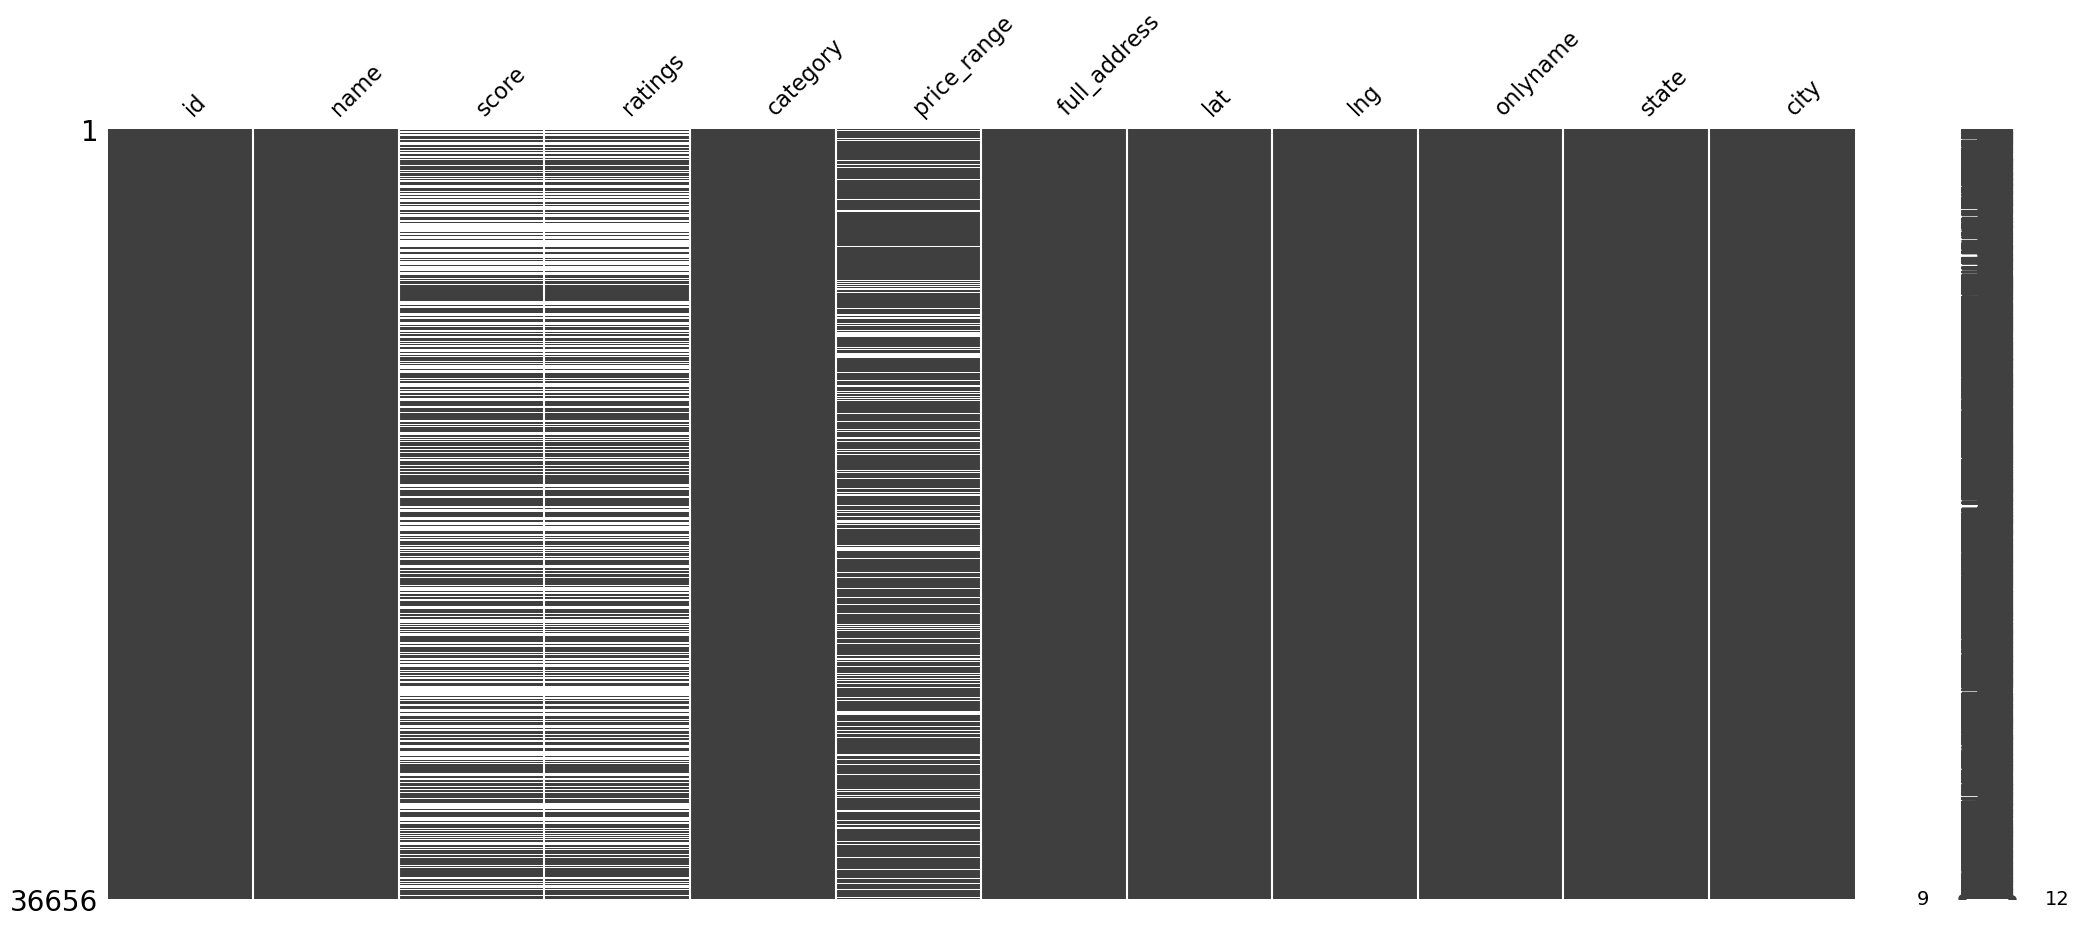

In [23]:
msno.matrix(df_restaurants)

<AxesSubplot: >

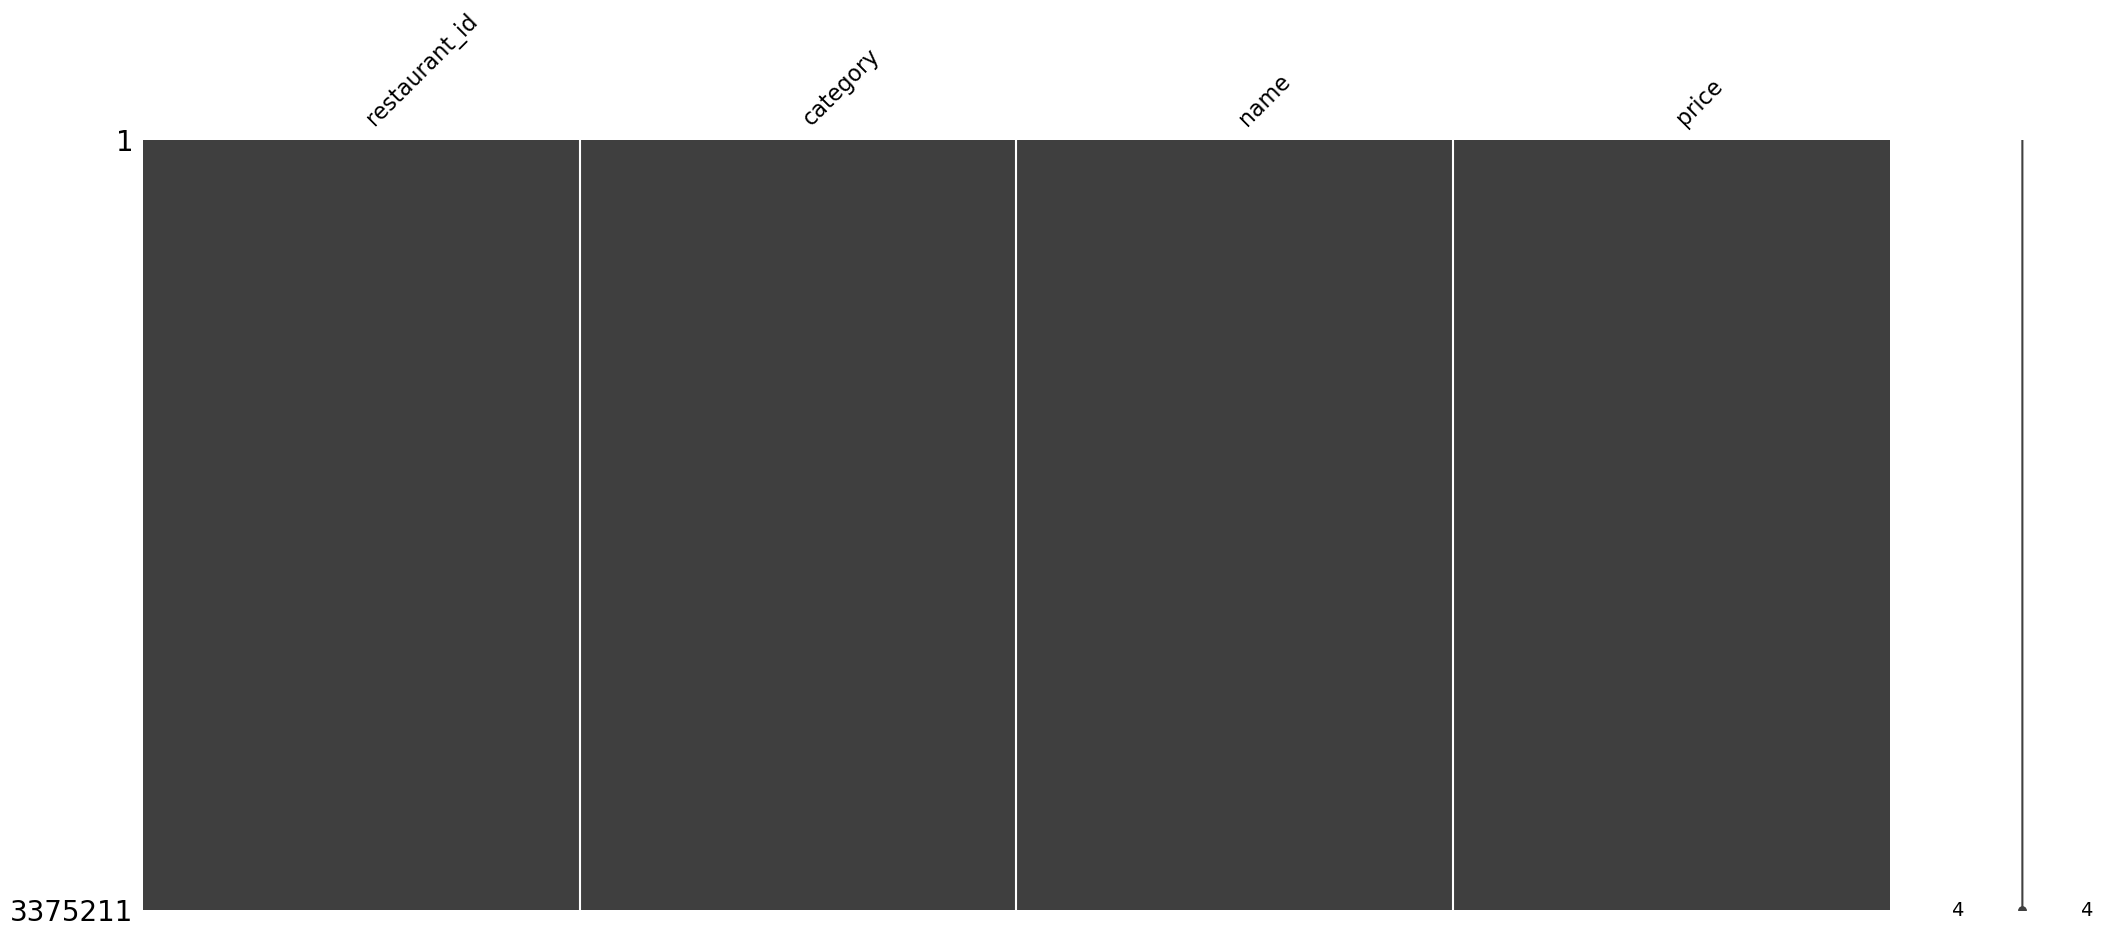

In [24]:
msno.matrix(df_restaurant_menus)

In [25]:
# rename columns r_ for restaurants
df_restaurants.columns = ['r_id', 'r_name', 'r_score', 'r_ratings','r_category','r_price_range','r_full_address','r_lat','r_lng','r_onlyname','r_state','r_city']    
# rename columns rm_ for restaurant_menus
df_restaurant_menus.columns = ['rm_restaurant_id', 'rm_category', 'rm_name', 'rm_price']    

print("Rows: ",df_restaurant_menus.shape[0])

# drop rows from df_restaurant_menus where restaurant_id doesn't exist in df_restaurants dataframe
valid_restaurant_id = df_restaurants['r_id'].tolist()
df_restaurant_menus = df_restaurant_menus[df_restaurant_menus['rm_restaurant_id'].isin(valid_restaurant_id)]

print("Rows after removing missing restaurants: ",df_restaurant_menus.shape[0])

if 'r_zip_code' in df_restaurants.columns:
    df_restaurants.drop('r_zip_code',axis=1,inplace=True)

if 'r_full_address' in df_restaurants.columns:
    df_restaurants.drop('r_full_address',axis=1,inplace=True)

#if 'r_lat' in df_restaurants.columns:
#    df_restaurants.drop('r_lat',axis=1,inplace=True)

#if 'r_lng' in df_restaurants.columns:
#    df_restaurants.drop('r_lng',axis=1,inplace=True)

    
df_restaurants_and_menus = pd.merge(df_restaurant_menus,df_restaurants,left_on='rm_restaurant_id',right_on='r_id')
df_restaurants_and_menus.head()



Rows:  3375211
Rows after removing missing restaurants:  2635651


,rm_restaurant_id,rm_category,rm_name,rm_price,r_id,r_name,r_score,r_ratings,r_category,r_price_range,r_lat,r_lng,r_onlyname,r_state,r_city
0,1,Extra Large Pizza,Extra Large Meat Lovers,15.99 USD,1,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"burgers, american, sandwiches",$,33.562365,-86.830703,PJ Fresh,AL,Birmingham
1,1,Extra Large Pizza,Extra Large Supreme,15.99 USD,1,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"burgers, american, sandwiches",$,33.562365,-86.830703,PJ Fresh,AL,Birmingham
2,1,Extra Large Pizza,Extra Large Pepperoni,14.99 USD,1,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"burgers, american, sandwiches",$,33.562365,-86.830703,PJ Fresh,AL,Birmingham
3,1,Extra Large Pizza,Extra Large BBQ Chicken &amp; Bacon,15.99 USD,1,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"burgers, american, sandwiches",$,33.562365,-86.830703,PJ Fresh,AL,Birmingham
4,1,Extra Large Pizza,Extra Large 5 Cheese,14.99 USD,1,PJ Fresh (224 Daniel Payne Drive),NaN,NaN,"burgers, american, sandwiches",$,33.562365,-86.830703,PJ Fresh,AL,Birmingham


In [26]:
# remove " USD" from the "rm_price" column and convert to float
df_restaurant_menus['rm_price'] = df_restaurant_menus['rm_price'].str.replace(' USD', '').astype(float)
print(df_restaurant_menus.head())

final_df_restaurants_rows = df_restaurants.shape[0]
final_df_restaurant_menus_rows = df_restaurant_menus.shape[0]

print("Restaurants orignal: ",original_df_restaurants_rows)
print("Restaurants final: ",final_df_restaurants_rows)
print("Restaurants difference: ",original_df_restaurants_rows-final_df_restaurants_rows)
print("%",round((original_df_restaurants_rows/final_df_restaurants_rows-1)*100,2))

print("Restaurant menus orignal: ",original_df_restaurant_menus_rows)
print("Restaurant menus final: ",final_df_restaurant_menus_rows)
print("Restaurant menus difference: ",original_df_restaurant_menus_rows-final_df_restaurant_menus_rows)
print("%",round((original_df_restaurant_menus_rows/final_df_restaurant_menus_rows-1)*100,2))



print("Rows in merged df_restaurants_and_menus: ",df_restaurants_and_menus.shape[0])

   rm_restaurant_id        rm_category                              rm_name  \
0                 1  Extra Large Pizza              Extra Large Meat Lovers   
1                 1  Extra Large Pizza                  Extra Large Supreme   
2                 1  Extra Large Pizza                Extra Large Pepperoni   
3                 1  Extra Large Pizza  Extra Large BBQ Chicken &amp; Bacon   
4                 1  Extra Large Pizza                 Extra Large 5 Cheese   

   rm_price  
0     15.99  
1     15.99  
2     14.99  
3     15.99  
4     14.99  
Restaurants orignal:  40227
Restaurants final:  36656
Restaurants difference:  3571
% 9.74
Restaurant menus orignal:  3375211
Restaurant menus final:  2635651
Restaurant menus difference:  739560
% 28.06
Rows in merged df_restaurants_and_menus:  2635651


In [27]:
df_restaurants_and_menus.to_csv('output_ANALYZE_df_restaurants_and_menus.csv', index=False)